In [1]:
import pandas as pd

# Load datasets
X_train = pd.read_csv("X_train.csv")  # Peptide sequences
train_labels = pd.read_csv("label_train.csv")  # Corresponding labels

# Combine features and labels
train_data = pd.concat([X_train, train_labels], axis=1)
train_data.columns = ['peptide_sequence', 'label']

# Load test data
X_test = pd.read_csv("X_test.csv")
test_labels = pd.read_csv("label_test.csv")
test_data = pd.concat([X_test, test_labels], axis=1)
test_data.columns = ['peptide_sequence', 'label']

In [2]:
train_data.head()

,peptide_sequence,label
0,DDRHKIVNVDQRQYG,1
1,EGNRPTNSIVFTKLT,1
2,TRQGGYSNDNTVIFR,1
3,LHGETFPYTAFDNNC,1
4,VMALEPVVGAAIAAP,1


In [3]:
test_data.head()

,peptide_sequence,label
0,TPETLFEIGSVSKTFTAT,1
1,HPGNTILHVDTIYNRPSNTT,1
2,YWAGIEFDVTHKGMALLHRL,1
3,EQGLLYMPQELAVSD,1
4,GARGFFQARHLEMDA,1


In [4]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the TF-IDF matrices
X_train_tfidf = joblib.load('X_train_tfidf.pkl')
X_test_tfidf = joblib.load('X_test_tfidf.pkl')


# Convert TF-IDF matrix to dense numpy array
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# Preprocess labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])

In [5]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch_geometric.data import Data

# Compute cosine similarity between documents (nodes)
similarity_matrix = cosine_similarity(X_train_dense)

# Define a threshold for edge creation (you can adjust this value)
threshold = 0.7

# Create edge indices based on cosine similarity > threshold
edge_index = np.array(np.where(similarity_matrix > threshold))
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Convert TF-IDF dense matrix to PyTorch tensor
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float)

# Convert labels to PyTorch tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

# Check the structure of the data object
print(data)

Data(x=[2872, 2872], edge_index=[2, 2872], y=[2872])


# Define the GNN Model

In [6]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()  # First GCN layer with ReLU activation
        x = self.conv2(x, edge_index)  # Second GCN layer
        return F.log_softmax(x, dim=1)  # Softmax for multi-class classification

In [7]:
# Define input, hidden, and output dimensions
input_dim = X_train_tensor.shape[1]  # The number of features per node (TF-IDF size)
hidden_dim = 64  # Hidden layer size (tune this)
output_dim = len(label_encoder.classes_)  # Number of unique classes

# Instantiate the model
model = GNN(input_dim, hidden_dim, output_dim)

# Define optimizer (Adam optimizer is commonly used)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define loss function (CrossEntropyLoss for classification)
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss as infinity
epochs_without_improvement = 0  # Counter to track epochs without improvement

# Training Loop

In [9]:
import matplotlib.pyplot as plt

# Lists to store loss and accuracy values for plotting
train_losses = []
accuracies = []

# Training loop
num_epochs = 100  # Set the number of epochs for training
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients

    # Forward pass
    out = model(data)  # Pass data through the model
    loss = loss_fn(out, data.y)  # Calculate the loss

    # Backward pass and optimization
    loss.backward()  # Backpropagation
    optimizer.step()  # Update model weights

    # Track the loss
    train_losses.append(loss.item())

    # Calculate accuracy
    _, predicted_labels = out.max(dim=1)  # Get the index of the class with the highest score
    correct = (predicted_labels == data.y).sum().item()  # Count correct predictions
    accuracy = correct / data.num_nodes  # Accuracy for node classification
    accuracies.append(accuracy)

    # Print the loss and accuracy every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy * 100:.2f}%")

Epoch 0/100, Loss: 0.6913, Accuracy: 55.29%
Epoch 10/100, Loss: 0.2124, Accuracy: 100.00%
Epoch 20/100, Loss: 0.0115, Accuracy: 100.00%
Epoch 30/100, Loss: 0.0010, Accuracy: 100.00%
Epoch 40/100, Loss: 0.0003, Accuracy: 100.00%
Epoch 50/100, Loss: 0.0002, Accuracy: 100.00%
Epoch 60/100, Loss: 0.0001, Accuracy: 100.00%
Epoch 70/100, Loss: 0.0001, Accuracy: 100.00%
Epoch 80/100, Loss: 0.0001, Accuracy: 100.00%
Epoch 90/100, Loss: 0.0001, Accuracy: 100.00%


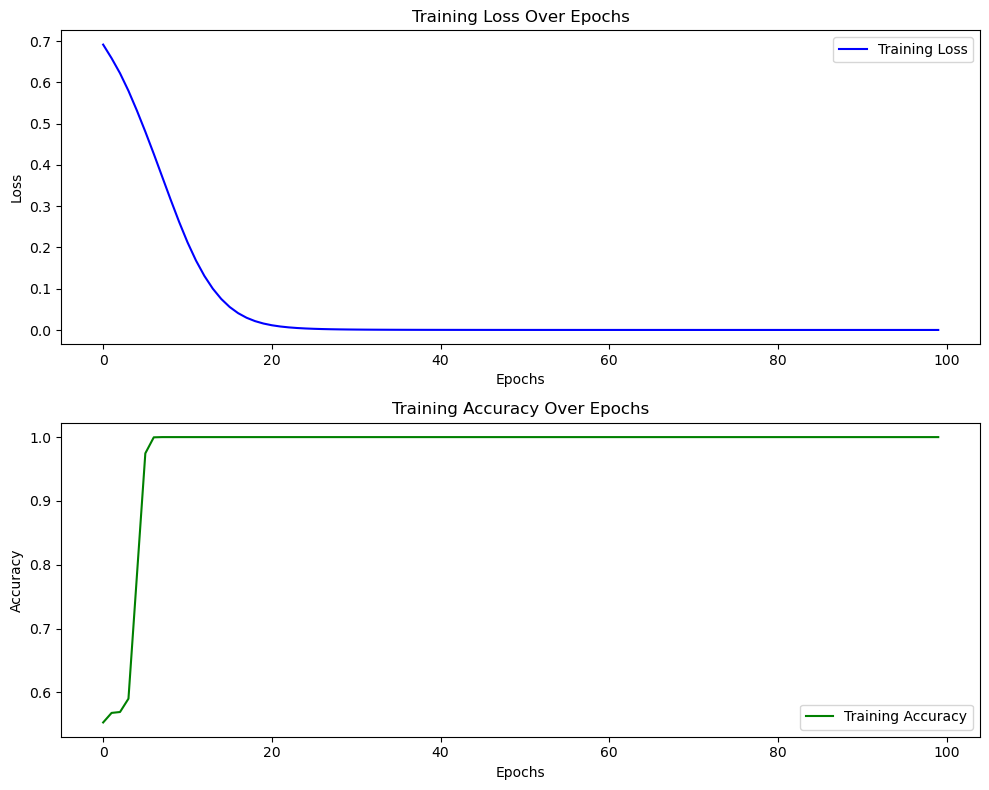

In [10]:
# Plot training loss and accuracy
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the training loss
ax[0].plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss Over Epochs')
ax[0].legend()

# Plot the training accuracy
ax[1].plot(range(num_epochs), accuracies, label='Training Accuracy', color='green')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy Over Epochs')
ax[1].legend()

plt.tight_layout()
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

In [12]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode

# Forward pass on training data or test data (using 'data' object here for simplicity)
out = model(data)

# Get the predicted class labels
_, predicted_labels = out.max(dim=1)

# Calculate the confusion matrix
cm = confusion_matrix(data.y.cpu().numpy(), predicted_labels.cpu().numpy())  # Move to CPU if needed
print(cm)

[[1627    0]
 [   0 1245]]


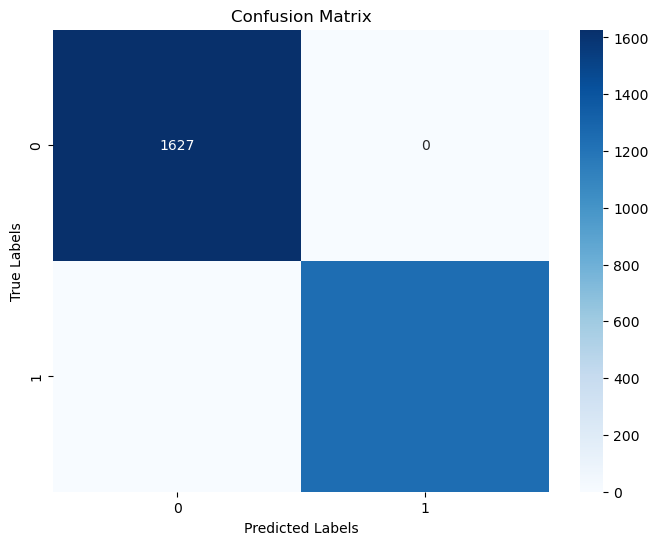

In [13]:
# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import matthews_corrcoef
import torch

In [15]:
# Forward pass on training data or test data
model.eval()  # Set the model to evaluation mode
out = model(data)

# Get the predicted class labels
_, predicted_labels = out.max(dim=1)

In [16]:
# Calculate the Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(data.y.cpu().numpy(), predicted_labels.cpu().numpy())
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Matthews Correlation Coefficient (MCC): 1.0000


In [17]:
# Set model to evaluation mode
model.eval()

GNN(
  (conv1): GCNConv(2872, 64)
  (conv2): GCNConv(64, 2)
)

# Test

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['peptide_sequence'])  # Fit on the training data

# Now you can use the same vectorizer to transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['peptide_sequence'])  # Transform the test data

In [20]:
import joblib

# Save the fitted vectorizer to a file
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [21]:
# Load the fitted vectorizer from the saved file
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Now transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['peptide_sequence'])

In [22]:
import torch

# Convert the TF-IDF matrix to a PyTorch tensor
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float)

# Assuming you have labels for the test data, convert them to a tensor
y_test_tensor = torch.tensor(label_encoder.transform(test_data['label']), dtype=torch.long)

In [27]:
# Assuming edge_index from training is valid for test data as well
test_edge_index = edge_index  # Use the same edge index if the structure is the same

# Alternatively, if you need to create a new edge_index for the test data, make sure it is correctly formed
# Example: edge_index for test_data (make sure it matches the graph structure for test data)
test_edge_index = torch.tensor([[0, 1], [1, 2]], dtype=torch.long)  # Example edge index for test

In [28]:
# Create a Data object for the test data
test_data = Data(x=X_test_tensor, edge_index=test_edge_index, y=y_test_tensor)

# Set the model to evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_out = model(test_data)

# Get the predicted class for each node
_, predicted_labels = test_out.max(dim=1)

# Evaluate the model on the test data
correct = (predicted_labels == test_data.y).sum().item()
accuracy = correct / test_data.y.size(0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5000


In [29]:
from sklearn.metrics import matthews_corrcoef

# Ensure the predicted labels and true labels are in the correct format
predicted_labels = predicted_labels.cpu().numpy()  # Convert to numpy array if they are in tensor form
true_labels = test_data.y.cpu().numpy()  # Convert to numpy array if they are in tensor form

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(true_labels, predicted_labels)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Matthews Correlation Coefficient (MCC): 0.0000
